In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



#Funciones de Python creadas por equipo Simulacion
from funcioneschicuadrado_continuas import*
from funciones_KS_test import*
from funciones_qq_pp_plot import*

In [31]:
datos_llegada_aviones=pd.read_excel('Datos-Caso-III.xlsx',sheet_name='DatosLlegadaAviones')
datos_llegada_aviones['Fecha de Llegada'] = pd.to_datetime(datos_llegada_aviones['Fecha de Llegada'])
datos_llegada_aviones.head()

,Fecha de Llegada,Tipo de Avión
0,2023-05-01 00:00:00.000,Mediano
1,2023-05-01 00:12:48.533,Grande
2,2023-05-01 00:20:31.919,Mediano
3,2023-05-01 00:31:48.641,Pequeño
4,2023-05-01 00:40:09.796,Pequeño


In [32]:
datos_pasajeros=pd.read_excel('Datos-Caso-III.xlsx',sheet_name='DatosPasajeros')
datos_pasajeros.head()

,Pasajero,Tipo de pasaporte,¿Lleva maleta?
0,1,Extranjero,Sí
1,2,Nacional no biométrico,No
2,3,Nacional no biométrico,Sí
3,4,Nacional no biométrico,Sí
4,5,Nacional no biométrico,Sí


In [33]:
datos_tiempo_servicio=pd.read_excel('Datos-Caso-III.xlsx',sheet_name='TiempoDeServicioBiométrico')
datos_tiempo_servicio.head()

,Persona atendida,Tipo de pasaporte,Tiempo de servicio (minutos)
0,1,Biométrico,0.349995
1,2,Biométrico,2.046627
2,3,Biométrico,0.232612
3,4,Biométrico,1.085411
4,5,Biométrico,2.585409


#### a.  Tiempo entre arribos de un avión desde un destino internacional para cada una de las siguientes franjas cuatro horarias: (6:00 am – 11:00 am; 11:00 am – 3:00 pm; 3:00 pm – 9:00 pm; 9:00 pm – 6:00 am) 

In [34]:
def asignar_franja(row):
    hora = row.hour
    if 6 <= hora < 11:
        return '6:00 am - 11:00 am'
    elif 11 <= hora < 15:
        return '11:00 am - 3:00 pm'
    elif 15 <= hora < 21:
        return '3:00 pm - 9:00 pm'
    else:
        return '9:00 pm - 6:00 am'

# Aplicar la función a la columna 'Fecha de Llegada'
datos_llegada_aviones['Franja Horaria'] = datos_llegada_aviones['Fecha de Llegada'].apply(asignar_franja)
datos_llegada_aviones.head()

,Fecha de Llegada,Tipo de Avión,Franja Horaria
0,2023-05-01 00:00:00.000,Mediano,9:00 pm - 6:00 am
1,2023-05-01 00:12:48.533,Grande,9:00 pm - 6:00 am
2,2023-05-01 00:20:31.919,Mediano,9:00 pm - 6:00 am
3,2023-05-01 00:31:48.641,Pequeño,9:00 pm - 6:00 am
4,2023-05-01 00:40:09.796,Pequeño,9:00 pm - 6:00 am


Inicialmente asignamos una franja horaria para para los datos de llegada, para despues proceder a hacer un analisis de tiempo entre llegadas para cada franja horaria

In [35]:
datos_llegada_aviones = datos_llegada_aviones.sort_values('Fecha de Llegada')

# Calcular el tiempo entre arribos
datos_llegada_aviones['Tiempo entre Arribos'] = datos_llegada_aviones['Fecha de Llegada']

# Filtrar datos para obtener tiempos entre arribos en cada franja horaria
datos_llegada_aviones['Tiempo entre Arribos (minutos)'] = datos_llegada_aviones['Fecha de Llegada'].diff().dt.total_seconds() / 60


datos_llegada_aviones.head()


,Fecha de Llegada,Tipo de Avión,Franja Horaria,Tiempo entre Arribos,Tiempo entre Arribos (minutos)
0,2023-05-01 00:00:00.000,Mediano,9:00 pm - 6:00 am,2023-05-01 00:00:00.000,NaN
1,2023-05-01 00:12:48.533,Grande,9:00 pm - 6:00 am,2023-05-01 00:12:48.533,12.808883
2,2023-05-01 00:20:31.919,Mediano,9:00 pm - 6:00 am,2023-05-01 00:20:31.919,7.723100
3,2023-05-01 00:31:48.641,Pequeño,9:00 pm - 6:00 am,2023-05-01 00:31:48.641,11.278700
4,2023-05-01 00:40:09.796,Pequeño,9:00 pm - 6:00 am,2023-05-01 00:40:09.796,8.352583


In [36]:
datos_llegada_aviones['Franja Horaria'].value_counts()

Franja Horaria
11:00 am - 3:00 pm    1289
6:00 am - 11:00 am    1046
3:00 pm - 9:00 pm     1021
9:00 pm - 6:00 am     1018
Name: count, dtype: int64

In [37]:
franjas = ['6:00 am - 11:00 am', '11:00 am - 3:00 pm', '3:00 pm - 9:00 pm', '9:00 pm - 6:00 am']


#### b. Tiempo de atención del módulo biométrico inteligente. (30 puntos)

In [38]:
media_tiempo = datos_tiempo_servicio['Tiempo de servicio (minutos)'].mean()
mediana_tiempo = datos_tiempo_servicio['Tiempo de servicio (minutos)'].median()
desviacion_estandar = datos_tiempo_servicio['Tiempo de servicio (minutos)'].std()
rango_intercuartilico = datos_tiempo_servicio['Tiempo de servicio (minutos)'].quantile(0.75) - datos_tiempo_servicio['Tiempo de servicio (minutos)'].quantile(0.25)

print(f"Media: {media_tiempo:.2f} minutos")
print(f"Mediana: {mediana_tiempo:.2f} minutos")
print(f"Desviación Estándar: {desviacion_estandar:.2f} minutos")
print(f"Rango Intercuartílico: {rango_intercuartilico:.2f} minutos")

Media: 1.34 minutos
Mediana: 0.92 minutos
Desviación Estándar: 1.33 minutos
Rango Intercuartílico: 1.48 minutos


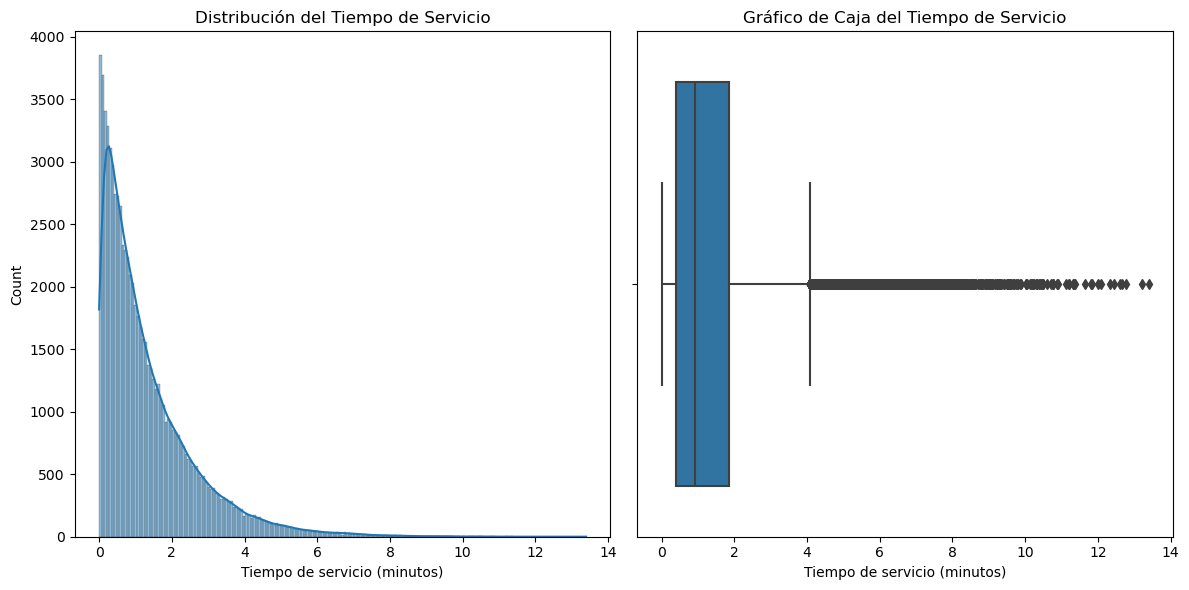

In [39]:
plt.figure(figsize=(12, 6))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(datos_tiempo_servicio['Tiempo de servicio (minutos)'], kde=True)
plt.title('Distribución del Tiempo de Servicio')

# Gráfico de Caja
plt.subplot(1, 2, 2)
sns.boxplot(x=datos_tiempo_servicio['Tiempo de servicio (minutos)'])
plt.title('Gráfico de Caja del Tiempo de Servicio')

plt.tight_layout()
plt.show()

### Discretas

#### c. Probabilidad de que el avión que acaba de aterrizar sea grande, mediano o pequeño. (10 puntos)

In [40]:
total_aviones = datos_llegada_aviones.shape[0]

conteo_por_tipo = datos_llegada_aviones['Tipo de Avión'].value_counts()

# Mostrar los conteos
print("Conteo por tipo de avión:")
print(conteo_por_tipo)

Conteo por tipo de avión:
Tipo de Avión
Mediano    2623
Grande     1314
Pequeño     437
Name: count, dtype: int64


In [41]:
probabilidades_tamano_avion = conteo_por_tipo / total_aviones

# Mostrar las probabilidades
print("\nProbabilidades de cada tipo de avión:")
print(probabilidades_tamano_avion)


Probabilidades de cada tipo de avión:
Tipo de Avión
Mediano    0.599680
Grande     0.300412
Pequeño    0.099909
Name: count, dtype: float64


#### d. Probabilidad asociada al tipo de pasajero/pasaporte. (10 puntos)

In [42]:
total_registros = datos_tiempo_servicio.shape[0]

# Contar la cantidad de cada tipo de pasaporte
conteo_por_tipo = datos_tiempo_servicio['Tipo de pasaporte'].value_counts()

print("Conteo por tipo de pasaporte:")
print(conteo_por_tipo)

Conteo por tipo de pasaporte:
Tipo de pasaporte
Biométrico    76203
Name: count, dtype: int64


In [29]:
probabilidades_tipo_pasajero = conteo_por_tipo / total_registros

# Mostrar las probabilidades
print("\nProbabilidades asociadas a cada tipo de pasaporte:")
print(probabilidades_tipo_pasajero)


Probabilidades asociadas a cada tipo de pasaporte:
Tipo de pasaporte
Biométrico    1.0
Name: count, dtype: float64


#### e. Probabilidad de que el pasajero haya viajado con maleta. (10 puntos)

In [44]:
total_pasajeros = datos_pasajeros.shape[0]
conteo_con_maleta = datos_pasajeros['¿Lleva maleta?'].value_counts().get('Sí', 0)

# Mostrar los conteos
print(f"Total de pasajeros: {total_pasajeros}")
print(f"Pasajeros con maleta: {conteo_con_maleta}")

probabilidad_con_maleta = conteo_con_maleta / total_pasajeros

# Mostrar la probabilidad
print(f"Probabilidad de que un pasajero haya viajado con maleta: {probabilidad_con_maleta:.2f}")


Total de pasajeros: 507530
Pasajeros con maleta: 372153
Probabilidad de que un pasajero haya viajado con maleta: 0.73
